# Loading models, data and imports

In [1]:
import os
import torch
from collections import OrderedDict
from dataclasses import dataclass
from data.datasets import get_dataset, get_num_classes_and_objects
from model.resnet_generator_v2 import ResnetGenerator128, ResnetGeneratorTransfFeats128
import utils.qualitative as Q
from utils.qualitative import transforms as Qtr


@dataclass
class MyArgs:
    dataset: str = ''
    model_path: str = ''
    model_depth_path: str = ''
    sample_path: str = ''
    model_name: str = ''
    model_depth_name: str = ''


def load_model(path: str, net: torch.nn.Module):
    if not os.path.isfile(args.model_path):
        print('Model not found')
        raise FileNotFoundError('Model not found')

    state_dict = torch.load(path)

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`nvidia
        new_state_dict[name] = v

    model_dict = net.state_dict()
    pretrained_dict = {k: v for k,
                       v in new_state_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    net.load_state_dict(model_dict)

    net.cuda()
    net.eval()

    return net


args = MyArgs()
args.dataset = 'clevr-rubber'
args.model_name = 'baseline'
args.model_path = 'outputs/clevr-rubber-baseline/G_200.pth'
args.model_depth_name = 'transf-feats3'
args.model_depth_path = 'outputs/clevr-rubber-transf-feats3/G_200.pth'

num_classes, num_o = get_num_classes_and_objects(args.dataset)

dataset = get_dataset(args.dataset, 128, 'val',
                      num_obj=num_o,
                      return_filenames=True, return_depth=True)

dataset_base = get_dataset(args.dataset, 128, 'val',
                           num_obj=num_o,
                           return_filenames=False, return_depth=False)

idx2name = dataset.idx2label

netGdepth = ResnetGeneratorTransfFeats128(
    num_classes=num_classes, output_dim=3).cuda()
netGdepth = load_model(args.model_depth_path, netGdepth)

netGbase = ResnetGenerator128(
    num_classes=num_classes, output_dim=3).cuda()
netGbase = load_model(args.model_path, netGbase)

thres = 2.0

Q.init(args, dataset, idx2name, num_o, num_classes, thres, netGbase, netGdepth)


In [2]:
layout_index = 29


# Direct comparison
Feed the same layout and noise to both models and compare the result

/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


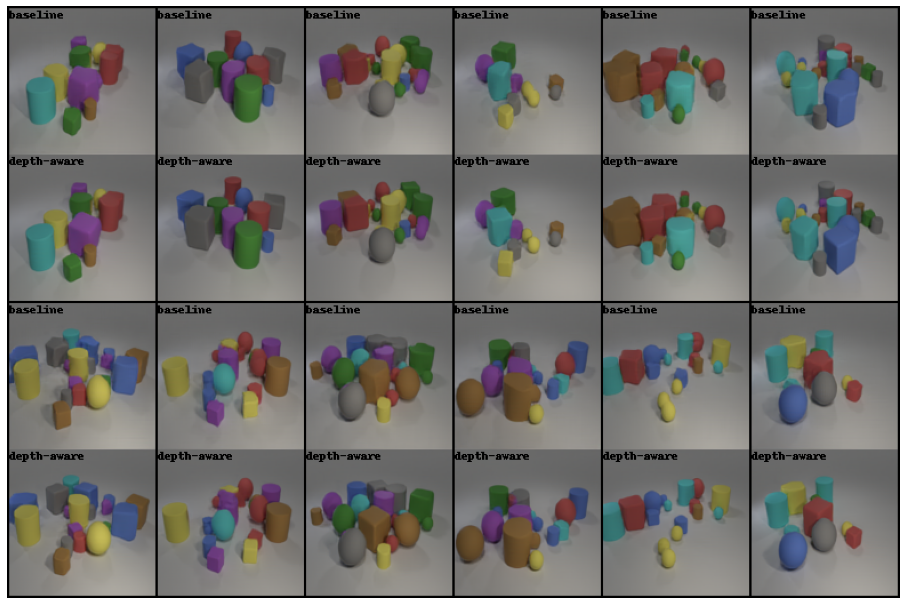

In [3]:
Q.direct_comparison()


# Diversity
We generate multiple images from the same layout to see the model is capable of generating diverse images given the same input

The model has three inputs: layout (bounding boxes and labels), a noise vector determining each object's appearance and another noise vector determining the overall image appearance.

We define a function that allows to fix some of these inputs and generating multiple images letting the others vary.

Generate multiple images form the same layout using both baseline and depth-aware models

Baseline model


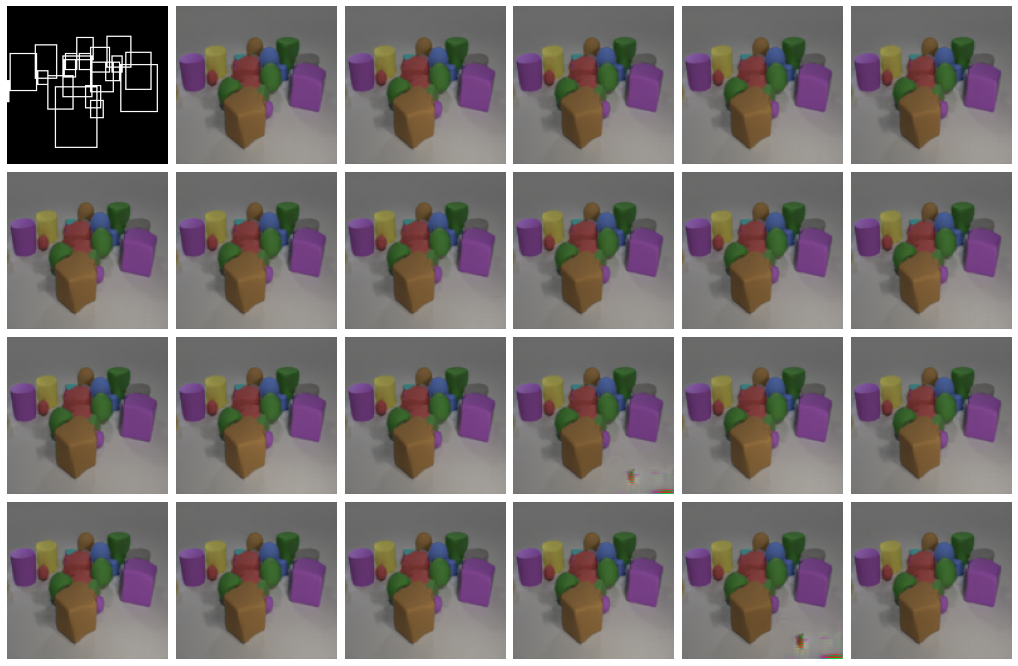

In [4]:
print('Baseline model')
Q.variable_inputs(['z_obj', 'z_img'], layout_idx=layout_index)


Depth-aware model


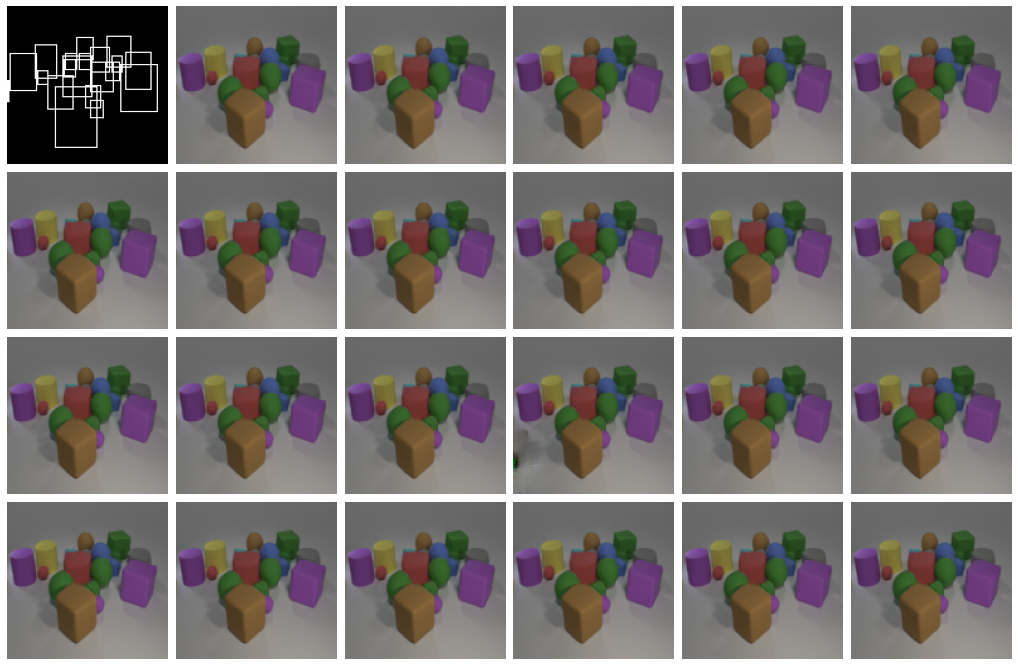

In [5]:
print('Depth-aware model')
Q.variable_inputs(['z_obj', 'z_img'],
                  layout_idx=layout_index, use_depth=True)


# Depth swap
Given a layout, we swap the depth values of two objects that form an occlusion, the ideal result would be that their ordering also gets invertend in the generated image.

For example, if object A in behind object B and we swap their depth values, object B should now be behind object A.

Fake 1 depths: [(0, tensor(0.7054)), (1, tensor(0.9613)), (2, tensor(0.8555)), (3, tensor(1.)), (4, tensor(0.3789)), (5, tensor(0.1254)), (6, tensor(0.6736)), (7, tensor(0.7906)), (8, tensor(0.8736)), (9, tensor(0.7218)), (10, tensor(0.1825)), (11, tensor(0.)), (12, tensor(0.4401)), (13, tensor(0.5999)), (14, tensor(0.5211)), (15, tensor(0.3638)), (16, tensor(0.0589)), (17, tensor(0.1556)), (18, tensor(-0.5000)), (19, tensor(-0.5000))]
Fake 2 depths: [(0, tensor(0.7054)), (1, tensor(0.9613)), (2, tensor(0.8555)), (3, tensor(1.)), (4, tensor(0.1254)), (5, tensor(0.3789)), (6, tensor(0.6736)), (7, tensor(0.7906)), (8, tensor(0.8736)), (9, tensor(0.7218)), (10, tensor(0.1825)), (11, tensor(0.)), (12, tensor(0.4401)), (13, tensor(0.5999)), (14, tensor(0.5211)), (15, tensor(0.3638)), (16, tensor(0.0589)), (17, tensor(0.1556)), (18, tensor(-0.5000)), (19, tensor(-0.5000))]


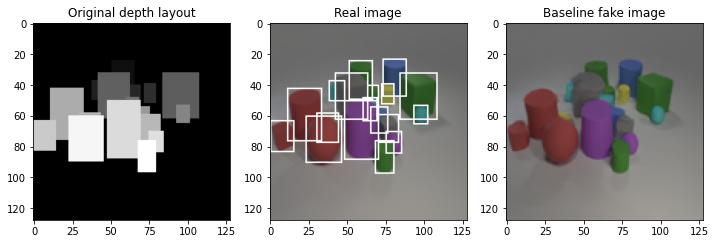

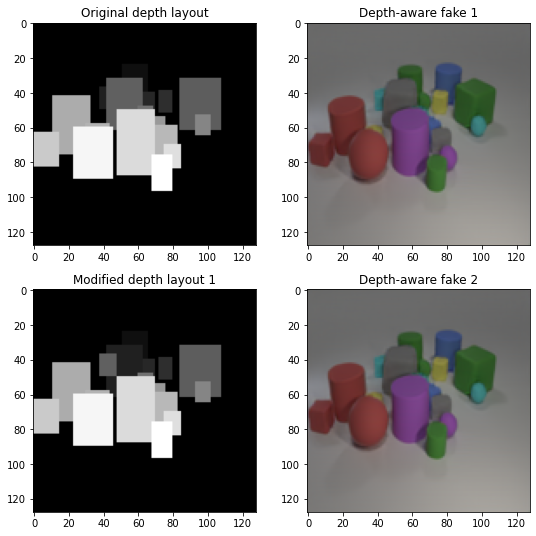

In [6]:
# Q.depth_transform(830, transform_idx=[0], transform=Qtr.swap_depth_transform, transform_args=(4,5))
Q.depth_transform(154, transform_idx=[
    0], transform=Qtr.swap_depth_transform, transform_args=(4, 5))
# Q.depth_transform(416, transform_idx=[0], transform=Qtr.swap_depth_transform, transform_args=(3,2))
# Q.depth_transform(216, transform_idx=[0], transform=Qtr.swap_depth_transform, transform_args=(3,2))


# Varying occlusions
We select an object partecipating in an occlusion and move it around so that its occluded area (or the occluded area of the object behind it) increases or decreases.

The object can also leave one occlusion and start occluding/being occluded by another object.

We generate multiple images by moving the object by N pixels each time and collect the images in a video for easier visualization.

In [7]:
Q.move_objects_video(num_gen=120, layout_idx=29, transform_bbox=[
                     4], transform=Qtr.move_right, vid_name='1')


Generating frames: 100%|██████████| 120/120 [00:08<00:00, 14.69it/s]


Saving generated frames...
Frames saved in samples/vids/clevr-rubber_1_29.avi


# KNN Analysis
We take `vis_knn` generated images and compute their `knn_k` neirest neighbors in the ground truth distribution.

Then we repeat the process by querying the generated images with ground truth images.

The neighbors are displayed in a grid, where the first image is the query and subsequent ones are the results.

Depth-aware model
Found samples in samples/clevr-rubber-transf-feats3
running KNN for sample dir: samples/clevr-rubber-transf-feats3, gt_dir: ./datasets/CLEVR_rubber/CLEVR_rubber_128/images/val


extracting info for KNN vis: 500it [00:31, 15.93it/s]
extracting info for KNN vis: 500it [00:29, 17.24it/s]


Query ground truths by sample


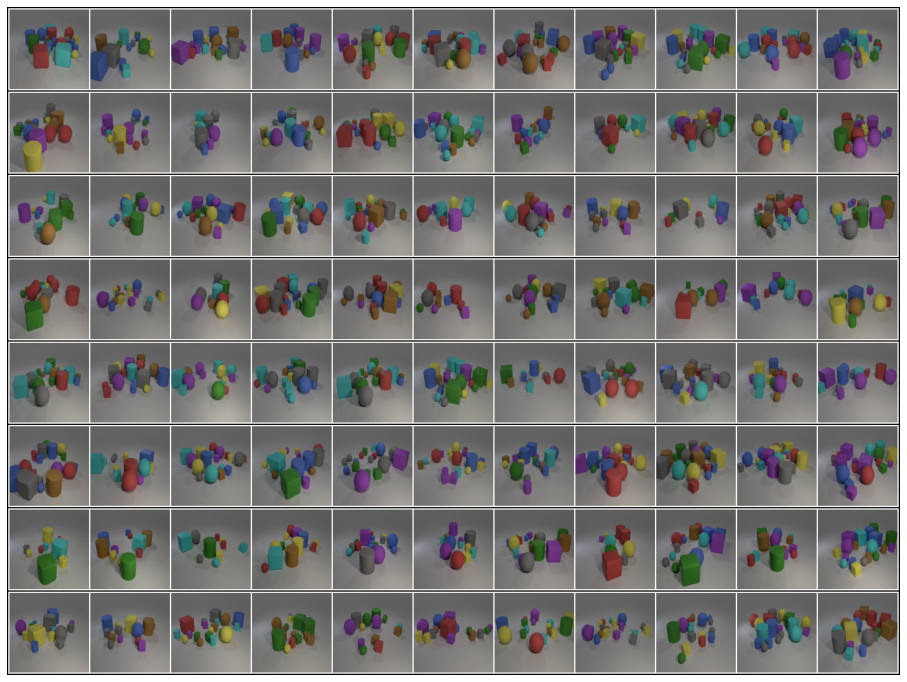

Query samples by ground truth


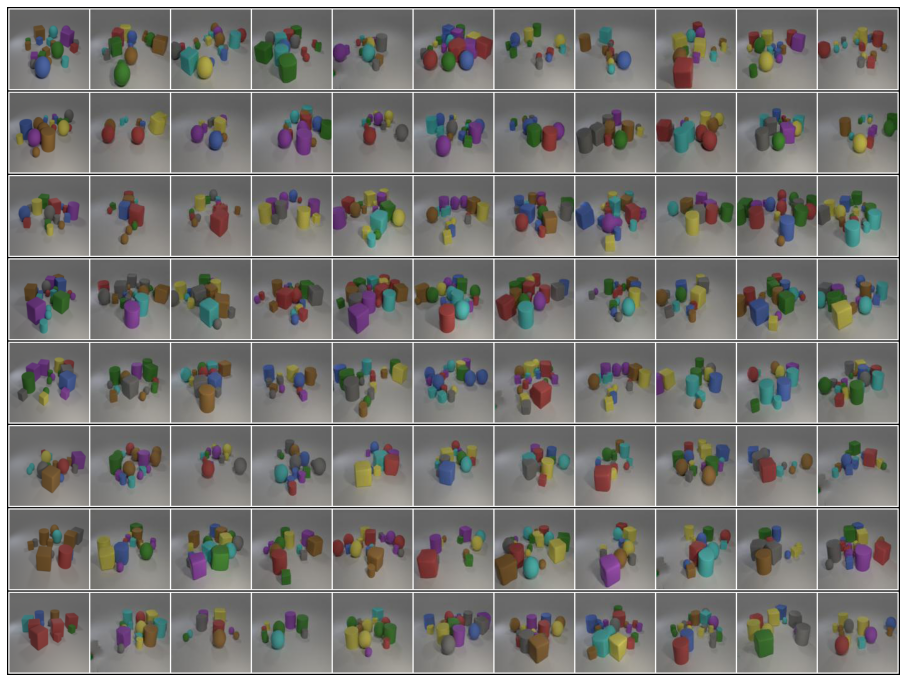

In [8]:
print('Depth-aware model')
Q.knn_analysis(vis_knn=8, knn_k=10)
